In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import mpmath as mp

# Set the precision for mpmath
mp.dps = 64

# Define the mapping function
def mapping(x, alpha):
    return mp.sin(alpha * mp.pi * x / 2) / mp.sin(alpha * mp.pi / 2)

# Define the function to compute weights μm
def compute_weights(zm, alpha):
    mu = mp.matrix(len(zm), 1)
    for n in range(len(zm)):
        if n == 0:
            mu[n] = (1/2) * (mp.asin(mapping(zm[n+1], alpha)) - mp.asin(mapping(zm[n], alpha)))
        elif n == len(zm) - 1:
            mu[n] = (1/2) * (mp.asin(mapping(zm[n], alpha)) - mp.asin(mapping(zm[n-1], alpha)))
        else:
            mu[n] = (1/2) * (mp.asin(mapping(zm[n+1], alpha)) - mp.asin(mapping(zm[n-1], alpha)))
    return mu

# Define the basis functions φn(x)
def phi_n(x, n, alpha):
    cn = mp.sqrt(1/mp.pi) if n == 0 else mp.sqrt(2/mp.pi)
    return cn * mp.cos(n * mp.acos(mapping(x, alpha)))

# Function to create the MPA expansion matrix
def create_expansion_matrix(alpha, N, n_order, cutoff=0):
    # Create the grid points zm
    zm = mp.linspace(-1, 1, N)

    # Compute the weights μm
    mu = compute_weights(zm, alpha)
    sqrt_mu = mp.matrix(len(mu), 1)
    for i in range(len(mu)):
        sqrt_mu[i] = mp.sqrt(mu[i])

    # Create the matrix A
    A = mp.matrix(N, n_order)
    for m in range(N):
        for n in range(n_order):
            A[m, n] = sqrt_mu[m] * phi_n(zm[m], n, alpha)

    # Compute the SVD of A
    U, s, Vh = mp.svd(A, full_matrices=False)
    sinv = mp.diag([1 / si if si > cutoff else 0 for si in s])  # Inverted singular values matrix with cutoff

    # Construct the expansion matrix
    expansion_matrix = Vh.T * sinv * U.T * mp.diag(sqrt_mu)

    return expansion_matrix

# Function to create the interpolation matrix
def create_interpolation_matrix(alpha, N, n_order, N_interpolated):
    expansion_matrix = create_expansion_matrix(alpha, N, n_order)

    # Create the interpolation points
    z_interpolated = mp.linspace(-1, 1, N_interpolated)

    # Create the matrix Phi for the interpolated points
    Phi_interpolated = mp.matrix(N_interpolated, n_order)
    for i in range(N_interpolated):
        for n in range(n_order):
            Phi_interpolated[i, n] = phi_n(z_interpolated[i], n, alpha)

    interpolation_matrix = Phi_interpolated * expansion_matrix

    return interpolation_matrix

# Function to compute accurate SVD extensions of mapped polynomials
def compute_svd_fourier_extension(n_coll, n_ext, n_phys, n_fourier, cutoff=0):
    """
    Computes the Fourier extension using Singular Value Decomposition (SVD).

    Parameters:
    n_coll (int): Number of overcollocation points.
    n_phys (int): Number of physical grid points.
    n_ext (int): Number of extension grid points.
    n_fourier (int): Number of Fourier modes.
    precision (int, optional): Precision for mpmath calculations. Default is 64.
    cutoff (float, optional): Cutoff value for singular values. Default is 0.

    Returns:
    tuple: Tuple containing the interpolated matrix, extended grid points, and grid spacing.
    """
    L_phys  = mp.mpf(2)
    dx_coll = L_phys / (n_coll - 1)  # Grid spacing for collocation points
    dx_phys = L_phys / (n_phys - 1)  # Grid spacing for physical points
    L_ext   = dx_phys * n_ext        # Extension domain length
    ks      = np.arange(-int(n_fourier / 2) + 1, int(n_fourier / 2) + 1)  # Fourier modes
    x_coll  = mp.matrix([i * dx_coll for i in range(n_coll)])  # Collocation grid points

    # Construct the matrix M
    M = mp.matrix(n_coll, len(ks))
    for i in range(n_coll):
        for j in range(len(ks)):
            M[i, j] = mp.exp(1j * ks[j] * 2 * mp.pi / (L_phys + L_ext) * x_coll[i])

    # Perform SVD on the matrix M
    U, s, Vh = mp.svd(M)
    sinv = mp.diag([1 / si if si > cutoff else 0 for si in s])  # Inverted singular values matrix with cutoff
    M_inv = Vh.H * sinv * U.H

    # Extended grid points
    x_ext = mp.matrix([i * dx_phys for i in range(n_ext + n_phys)])

    # Construct the extended function
    rec = mp.matrix(len(x_ext), len(ks))
    for i in range(len(x_ext)):
        for j in range(len(ks)):
            rec[i, j] = mp.exp(1j * ks[j] * 2 * mp.pi / (L_phys + L_ext) * x_ext[i])

    M_int = rec * M_inv
    return M_int

# Test function
f = lambda x: np.sin(np.pi * x)

# Example usage
# Parameters (adjust as necessary to match the parameters used when saving the file)

param_dict = {
    "double_matmul_high": {
        "alpha": 0.5,
        "n_phys": 32,
        "n_ext": 32,
        "n_order": 30,
        "n_coll": 150,
        "n_fourier": 40,
        "mpa_fit_cutoff": 0,
        "svd_extension_cutoff": 1e-8,
        "precision": 128
    },
    "double_matmul_low": {
        "alpha": 0.5,
        "n_phys": 32,
        "n_ext": 32,
        "n_order": 28,
        "n_coll": 150,
        "n_fourier": 40,
        "mpa_fit_cutoff": 0,
        "svd_extension_cutoff": 1e-7,
        "precision": 128
    },
    "single_matsplit_high": {
        "alpha": 0.5,
        "n_phys": 32,
        "n_ext": 32,
        "n_order": 28,
        "n_coll": 150,
        "n_fourier": 48,
        "mpa_fit_cutoff": 0,
        "svd_extension_cutoff": 1e-4,
        "precision": 128
    },
    "single_matsplit_low": {
        "alpha": 0.5,
        "n_phys": 32,
        "n_ext": 32,
        "n_order": 27,
        "n_coll": 150,
        "n_fourier": 48,
        "mpa_fit_cutoff": 0,
        "svd_extension_cutoff": 1e-4,
        "precision": 128
    },
}

params = param_dict["single_matsplit_high"]
# Extracting individual parameters
alpha = params['alpha']
n_phys = params['n_phys']
n_ext = params['n_ext']
n_order = params['n_order']
n_coll = params['n_coll']
n_fourier = params['n_fourier']
mpa_fit_cutoff = params['mpa_fit_cutoff']
svd_extension_cutoff = params['svd_extension_cutoff']
precision = params['precision']

# Prepare computation
mp.dps               = precision
x_phys               = mp.linspace(-1, 1, n_phys)
x_coll               = mp.linspace(-1, 1, n_coll)

# Compute extension matrix
svd_extension_matrix = compute_svd_fourier_extension(n_coll, n_ext, n_phys, n_fourier, svd_extension_cutoff)

extended_polynomials = []
for order in range(n_order):
    # Compute basis function values at collocation points for SVD extension with overcollocation
    mapped_polynomial = mp.matrix([phi_n(mp.mpf(x), order, alpha) for x in x_coll])
    # Compute extension by multiplication with svd_extension_matrix
    extended_polynomials.append(svd_extension_matrix * mapped_polynomial)

# Stack the extended polynomials vertically and transpose to form the polynomial matrix
polynomial_matrix = mp.matrix(len(extended_polynomials[0]), len(extended_polynomials))
for i in range(len(extended_polynomials)):
    polynomial_matrix[:, i] = extended_polynomials[i]

# Matrix that expands input function of length n_phys in terms of mapped polynomials using SVD
# Returns n_order weights.
expansion_matrix   = create_expansion_matrix(alpha, n_phys, n_order, mpa_fit_cutoff)


# Combine matrices to obtain Mapped Polynomial extension matrix
extension_matrix = polynomial_matrix * expansion_matrix



extension_matrix = np.array(extension_matrix.tolist(), dtype=complex)
polynomial_matrix = np.array(polynomial_matrix.tolist(), dtype=complex)
expansion_matrix = np.array(expansion_matrix.tolist(), dtype=complex)

# Define the base filename format
base_filename = (
    f"alpha{alpha}_nphys{n_phys}_next{n_ext}_norder{n_order}_"
    f"ncoll{n_coll}_nfourier{n_fourier}_mpafit{mpa_fit_cutoff}_"
    f"svdextcutoff{svd_extension_cutoff}_precision{precision}_mpacutoff{mpa_fit_cutoff}"
)

# Save matrices to .bin files
extension_matrix_filename = f"bins/{base_filename}_mpa_extension_matrix.bin"
polynomial_matrix_filename = f"bins/{base_filename}_extended_polynomials.bin"
expansion_matrix_filename = f"bins/{base_filename}_mpa_matrix.bin"

extension_matrix.tofile(extension_matrix_filename)
polynomial_matrix.tofile(polynomial_matrix_filename)
expansion_matrix.tofile(expansion_matrix_filename)

print(f"Saved extension matrix to {extension_matrix_filename}")
print(f"Saved polynomial matrix to {polynomial_matrix_filename}")
print(f"Saved expansion matrix to {expansion_matrix_filename}")



Saved extension matrix to bins/alpha0.5_nphys32_next32_norder28_ncoll150_nfourier48_mpafit0.0001_svdextcutoff0.0001_precision128_mpacutoff0.0001_mpa_extension_matrix.bin
Saved polynomial matrix to bins/alpha0.5_nphys32_next32_norder28_ncoll150_nfourier48_mpafit0.0001_svdextcutoff0.0001_precision128_mpacutoff0.0001_extended_polynomials.bin
Saved expansion matrix to bins/alpha0.5_nphys32_next32_norder28_ncoll150_nfourier48_mpafit0.0001_svdextcutoff0.0001_precision128_mpacutoff0.0001_mpa_matrix.bin


C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1655662496.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  r = extension_matrix.astype(prec) @ f_values.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1655662496.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff = expansion_matrix.astype(prec) @ f_values.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1655662496.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  r = polynomial_matrix.astype(prec) @ coeff.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1655662496.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  r = extension_matrix.astype(prec) @ f_values.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1655662496.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff = expansion_matrix.astype(prec) @ f_values.astype(

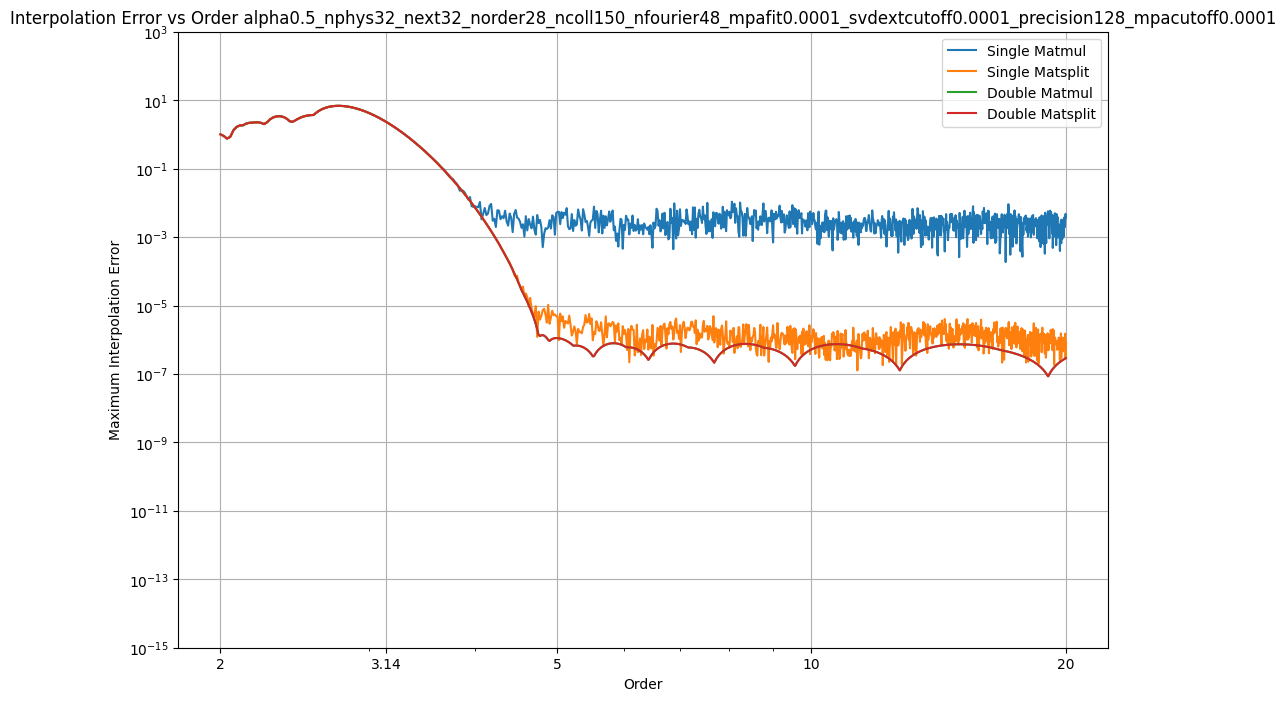

In [38]:


# Function to compute the FFT of a periodic function and interpolate it on a given grid
def interpolate_using_fft(f_values, x, N_interpolated):
    # Compute the FFT of the input function
    f_fft = np.fft.fft(f_values)

    # Create the new grid for interpolation
    x_interpolated = np.linspace(-1, 1, N_interpolated, endpoint=False)

    # Zero-pad the FFT coefficients to the desired length for interpolation
    f_fft_padded = np.zeros(N_interpolated, dtype=complex)
    M = len(f_fft)
    f_fft_padded[:M//2] = f_fft[:M//2]
    f_fft_padded[-M//2:] = f_fft[-M//2:]

    # Compute the inverse FFT on the padded FFT coefficients
    f_interpolated = np.fft.ifft(f_fft_padded) * N_interpolated / M

    return x_interpolated, f_interpolated

# Function to make periodic using different methods
def make_periodic_1(f_values):
    prec = np.single
    r = extension_matrix.astype(prec) @ f_values.astype(prec)
    r[:len(f_values)] = f_values
    return r[:-1]

def make_periodic_2(f_values):
    prec = np.single
    coeff = expansion_matrix.astype(prec) @ f_values.astype(prec)
    r = polynomial_matrix.astype(prec) @ coeff.astype(prec)
    r[:len(f_values)] = f_values
    return r[:-1]

def make_periodic_3(f_values):
    prec = np.double
    r = extension_matrix.astype(prec) @ f_values.astype(prec)
    r[:len(f_values)] = f_values
    return r[:-1]

def make_periodic_4(f_values):
    prec = np.double
    coeff = expansion_matrix.astype(prec) @ f_values.astype(prec)
    r = polynomial_matrix.astype(prec) @ coeff.astype(prec)
    r[:len(f_values)] = f_values
    return r[:-1]


make_periodic_funcs = [
    make_periodic_1,
    make_periodic_2,
    make_periodic_3,
    make_periodic_4,
]


N = 32

def f(x, k):
    return np.sin(x * k * np.pi)

x = np.linspace(-1, 1, n_phys, endpoint=False)
N_interpolated = 1024
ppws = np.linspace(2, 20, 1000)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

method_dict = {
    0: "Single Matmul",
    1: "Single Matsplit",
    2: "Double Matmul",
    3: "Double Matsplit",
}

for func_id in range(4):
    errors = []
    for ppw in ppws:
        k = N/ppw
        f_values_k = f(x, k)
        f_periodic = make_periodic_funcs[func_id](f_values_k)

        # Adjust N_interpolated according to the length of f_periodic
        N_interpolated_adjusted = int(N_interpolated * len(f_periodic) / N)

        x_interpolated, f_interpolated = interpolate_using_fft(f_periodic, x, N_interpolated_adjusted)
        f_exact = f(np.linspace(-1, 1, N_interpolated, endpoint=False), k)

        # Chop off the extension for the interpolation error
        f_interpolated_chopped = f_interpolated[:len(f_exact)]
        interpolation_error = np.max(np.abs(f_exact - f_interpolated_chopped)[128:-128])
        errors.append(interpolation_error)

    ax.loglog(ppws, errors, label=method_dict[func_id])

ax.set_xlabel('Order')
ax.set_ylabel('Maximum Interpolation Error')
ax.set_yscale('log')
ax.set_ylim([1e-15, 1e3])

ax.set_title(f'Interpolation Error vs Order {base_filename}')
ax.grid(True)
ax.set_xticks([2, 3.14,  5, 10, 20])
ax.set_xticklabels([2, 3.14, 5, 10, 20])
ax.legend()
plt.savefig(f"runs/{base_filename}.png", bbox_inches='tight')
plt.show()
